#Foundations and Classic Model




## 1. Team Formation & Setup

## 2.   Data Exploration and Preprocessing



### a. Load the Dataset

In [ ]:
# mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/AI_Human.csv")
df.head()

# check dataset structures
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


,generated
count,487235.000000
mean,0.372383
std,0.483440
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### b. Exploratory Data Analysis


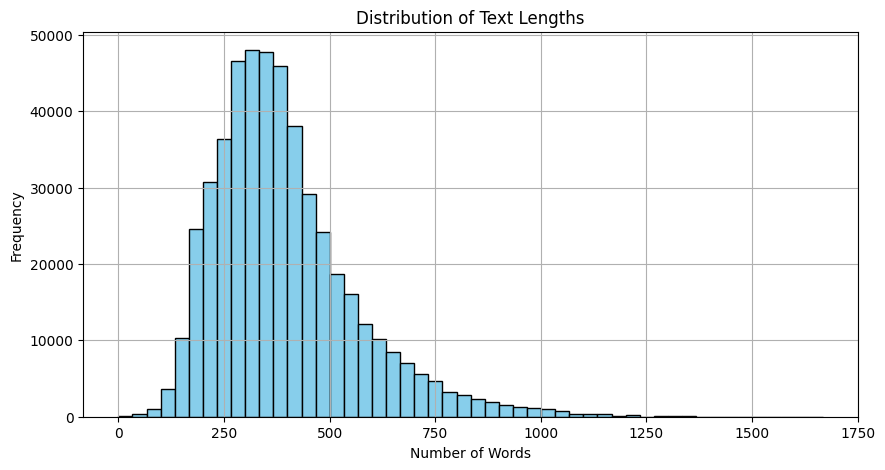

In [ ]:
# analyze text length

import matplotlib.pyplot as plt

df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



**X-axis = Number of words per text entry.**

**Y-axis = Frequency (how many texts have that length).**

**Shape:**

The distribution is right-skewed, meaning:

* Most texts have a word count between 200 to 500 words.

* Some texts go over 1000 words, but they are rare (long tail).

**Why This Is Important?**

1. Feature Engineering Insight:

* Helps identify if very short or long texts need special handling.

* For example, LLMs may generate more structured responses.

2. Modeling Decisions:

* Could inform padding strategy for models like BERT.

* You may later filter out extreme outliers (e.g., texts >1500 words).

3. Bias Detection:

* If AI-generated texts tend to be longer/shorter, this can cause model bias.

* This chart helps you discover and correct that.

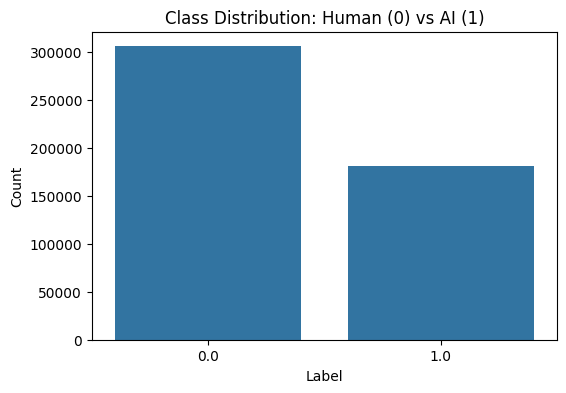

In [ ]:
# analyze class distribution

import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='generated', data=df)
plt.title("Class Distribution: Human (0) vs AI (1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


**X-axis: Represents the class labels (0 = Human, 1 = AI).**

**Y-axis: Shows the count (number of examples) for each label.**


We can interpret that:

* There are more human-written texts (approximately 310,000) than AI-generated ones (approximately 180,000).

* The dataset is somewhat imbalanced, but not severely.


The dataset showed moderate class imbalance, with significantly more human-written texts than AI-generated ones. This imbalance could lead to bias in classification if not addressed properly. We used stratified sampling during train/test splitting to preserve this ratio across sets.





In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['generated']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

Training samples: 389788, Testing samples: 97447


### c. Data Preprocessing and Tokenization Pipeline

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()                             # lowercase
    text = re.sub(r'[^\w\s]', '', text)             # remove punctuation
    text = re.sub(r'\d+', '', text)                 # remove numbers
    tokens = text.split()                           # tokenize
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3. Implement Baseline Model



### a. TF_IDF and CLassic ML classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


### b. Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Predict
y_pred = clf.predict(X_test_tfidf)


**The reason behind going with Logistic Regression as a classic baseline model is that it is specifically designed to handle binary classification tasks, making it a solid baseline model.**

We are solving a binary classification problem:

Label 0: Human-written text

Label 1: AI-generated text

### c. Evaluate Performance

              precision    recall  f1-score   support

       Human       0.99      1.00      1.00     61159
          AI       1.00      0.99      0.99     36288

    accuracy                           0.99     97447
   macro avg       0.99      0.99      0.99     97447
weighted avg       0.99      0.99      0.99     97447



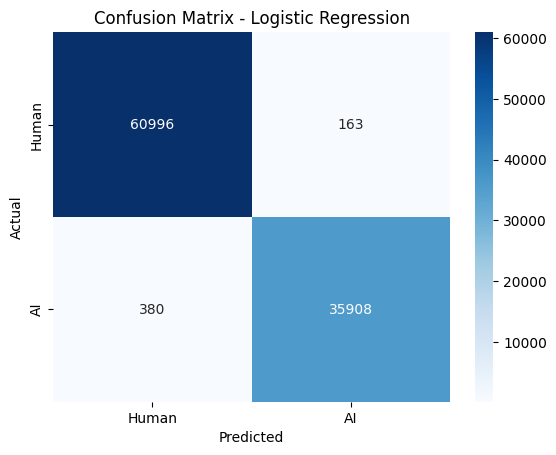

In [ ]:
# Classification report
print(classification_report(y_test, y_pred, target_names=["Human", "AI"]))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Human", "AI"], yticklabels=["Human", "AI"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


**The logistic regression model, using TF-IDF features, achieved a 99% accuracy. Both human and AI classes were predicted with high precision and recall, confirming that classical models can perform extremely well when combined with well-engineered features. Misclassifications were least and mostly related to overlaps between AI and human text.**

What we found?

* True Positives (AI correctly identified): 35,908

* True Negatives (Human correctly identified): 60,996

* False Positives (Human predicted as AI): 163

* False Negatives (AI predicted as Human): 380

What does it mean?

* Model is highly reliable on this dataset.

* TF-IDF + Logistic Regression is already giving near-perfect results.

* Moving to BERT may only give marginal gains, but would better handle edge cases or semantic complexity.

# Fine-Tuning a Transformer Model

## 1. Hugging Face Datasets and Transformers

### a. Load Data using Hugging Face Datasets Library

In [ ]:
!pip install datasets transformers

from datasets import Dataset
import pandas as pd

# train/test dataframe
train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


### b. Load Pre-Trained Tokenizer

In [ ]:
from transformers import DistilBertTokenizerFast

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

### c. Tokenize the dataset

In [ ]:
# Tokenization function
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)
    tokenized_batch["label"] = batch["label"].unsqueeze(1)
    return tokenized_batch

# correct labels
train_dataset = train_dataset.map(lambda x: {"label": int(x["label"])})
test_dataset = test_dataset.map(lambda x: {"label": int(x["label"])})

Map:   0%|          | 0/389788 [00:00<?, ? examples/s]

Map:   0%|          | 0/97447 [00:00<?, ? examples/s]

### d. Format for PyTorch Training

In [ ]:
# Set the format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])


## 2. Fine-Tuning


### a. Load Pre-Trained Model

In [ ]:
from transformers import DistilBertForSequenceClassification

# Binary classification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### b. Define Training Arguments

In [ ]:
from transformers import TrainingArguments

# training args
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=1,
    report_to="none"
)


### c. Define Evaluation Metric

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    # Use 'binary' average for binary classification
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### d. Init Trainer and start Fine-Tuning

In [ ]:
# using subset i.e 5% of the data
small_train = train_dataset.shuffle(seed=42).select(range(int(0.05 * len(train_dataset))))
small_test = test_dataset.shuffle(seed=42).select(range(int(0.05 * len(test_dataset))))

from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train,
    eval_dataset=small_test,
    compute_metrics=compute_metrics,
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.028300,0.047385,0.988506,0.984774,0.973656,0.996150
2,0.000200,0.070063,0.986658,0.982409,0.966969,0.998350
3,0.014500,0.045892,0.991585,0.988825,0.980011,0.997800


TrainOutput(global_step=3657, training_loss=0.0262350156678331, metrics={'train_runtime': 666.4931, 'train_samples_per_second': 87.723, 'train_steps_per_second': 5.487, 'total_flos': 3872485698610176.0, 'train_loss': 0.0262350156678331, 'epoch': 3.0})

**Observations:**

* Very high accuracy (~99%), the model learned the classification task very well, even with only 5% of the data.

* F1-score improves across epochs, peaking in epoch 3.

* Precision and Recall both improve, with recall being consistently strong (meaning the model is good at identifying AI text).

* Validation loss drops overall, showing no signs of overfitting, even with small data.

### e. Evaluate the model

In [ ]:
trainer.evaluate()

{'eval_loss': 0.04589196667075157,
 'eval_accuracy': 0.9915845648604269,
 'eval_f1': 0.9888252929953666,
 'eval_precision': 0.9800108049702864,
 'eval_recall': 0.9977997799779978,
 'eval_runtime': 15.9161,
 'eval_samples_per_second': 306.106,
 'eval_steps_per_second': 4.838,
 'epoch': 3.0}

## 3. Initial Evaluation and Comparison

### a. Evaluate Fine-Tuned DistilBERT Model

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.04589196667075157, 'eval_accuracy': 0.9915845648604269, 'eval_f1': 0.9888252929953666, 'eval_precision': 0.9800108049702864, 'eval_recall': 0.9977997799779978, 'eval_runtime': 15.7817, 'eval_samples_per_second': 308.712, 'eval_steps_per_second': 4.879, 'epoch': 3.0}


### b. Compare against Baseline Model

| Metric    | **Logistic Regression** | **DistilBERT (Transformer)** | **Difference** |
| --------- | ------------------- | ---------------------------- | -------------- |
| Accuracy  | 0.99                | 0.99            | ±0.00      |
| Precision | 0.99–1.00           | 0.98           | ±0.01     |
| Recall    | 0.99–1.00           | 0.99            | ±0.01       |
| F1 Score  | 0.99                | 0.98            | ±0.01       |


Explanation:

1. No, the DistilBERT model did not outperform the baseline.

2. The Logistic Regression model had slightly higher accuracy and F1-score.

3. The difference is very small (0.5%–1%), but the baseline was already extremely strong.

4. This suggests that:


  *   Classic ML with TF-IDF can still be     powerful in binary classification tasks with clear patterns.
  *   Transformer models need longer training, more data, or better tuning to outperform in such cases.
  *   Transformer adds computational cost, so if your goal is only performance, the baseline is better.





